# Puntaje Bancario: Aprobación de Crédito Mediante Redes Neuronales

En esta ocasión se busca desarrollar un protocolo de pruebas que permita encontrar la mejor arquitectura de red neuronal completamente conectada. En esta ocasión debe utilizar la librería SciKit-Learn (sklearn.neural_network) para diseñar cada red. Además, veremos algunos conceptos de _feature engineering_ para analizar los datos a nuestra disposición.

Debe completar las celdas vacías y seguir las instrucciones anotadas en el cuaderno.



In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd   
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
import itertools

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, balanced_accuracy_score, confusion_matrix  
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV

from sklearn import svm
from sklearn.ensemble import RandomForestClassifier

Se tienen dos archivos:

`application_record.csv`: posee información general (puede observar los nombres de las columnas a continuación) sobre cada usuario, definido a partir de una ID única.

- ID: número de cliente
- CODE_GENDER: género
- FLAG_OWN_CAR:	posee un automóvil
- FLAG_OWN_REALTY: posee un inmueble
- CNT_CHILDREN:	cantidad de hijos
- AMT_INCOME_TOTAL:	ingresos anuales
- NAME_INCOME_TYPE: categoría de ingresos
- NAME_EDUCATION_TYPE: nivel educativo
- NAME_FAMILY_STATUS estado civil
- NAME_HOUSING_TYPE: forma de vivienda (e.g. renta, apartamento propio, ...)
- DAYS_BIRTH: fecha de nacimiento, en días hacia atrás desde la actualidad, -1 significa ayer

- DAYS_EMPLOYED: tiempo de empleo, en días hacia atrás desde la actualidad, -1 significa ayer. Si es positivo, el usuario se encuentra desempleado.
- FLAG_MOBIL: teléfono móvil
- FLAG_WORK_PHONE: teléfono de trabajo
- FLAG_PHONE: teléfono
- FLAG_EMAIL: email
- OCCUPATION_TYPE: ocupación
- CNT_FAM_MEMBERS: tamaño de familia


`credit_record.csv`:

- ID: número de cliente
- MONTHS_BALANCE: mes de registro
- ESTADO:
    - 0: 1-29 días atrasados
    - 1: 30-59 días atrasados
    - 2: 60-89 días atrasados
    - 3: 90-119 días atrasados
    - 4: 120-149 días atrasados
    - 5: Atrasados o incobrables, cancelaciones durante más de 150 días
    - C: cancelado ese mes X: sin préstamo durante el mes

In [3]:
# cargar base
data = pd.read_csv("creditCardScore/application_record.csv", encoding = 'utf-8') 
record = pd.read_csv("creditCardScore/credit_record.csv", encoding = 'utf-8')
data

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS
0,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0
1,5008805,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0
2,5008806,M,Y,Y,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,-21474,-1134,1,0,0,0,Security staff,2.0
3,5008808,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0
4,5008809,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
438552,6840104,M,N,Y,0,135000.0,Pensioner,Secondary / secondary special,Separated,House / apartment,-22717,365243,1,0,0,0,NaN,1.0
438553,6840222,F,N,N,0,103500.0,Working,Secondary / secondary special,Single / not married,House / apartment,-15939,-3007,1,0,0,0,Laborers,1.0
438554,6841878,F,N,N,0,54000.0,Commercial associate,Higher education,Single / not married,With parents,-8169,-372,1,1,0,0,Sales staff,1.0
438555,6842765,F,N,Y,0,72000.0,Pensioner,Secondary / secondary special,Married,House / apartment,-21673,365243,1,0,0,0,NaN,2.0


In [4]:
plt.rcParams['figure.facecolor'] = 'white'

In [5]:
data

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS
0,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0
1,5008805,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0
2,5008806,M,Y,Y,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,-21474,-1134,1,0,0,0,Security staff,2.0
3,5008808,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0
4,5008809,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
438552,6840104,M,N,Y,0,135000.0,Pensioner,Secondary / secondary special,Separated,House / apartment,-22717,365243,1,0,0,0,NaN,1.0
438553,6840222,F,N,N,0,103500.0,Working,Secondary / secondary special,Single / not married,House / apartment,-15939,-3007,1,0,0,0,Laborers,1.0
438554,6841878,F,N,N,0,54000.0,Commercial associate,Higher education,Single / not married,With parents,-8169,-372,1,1,0,0,Sales staff,1.0
438555,6842765,F,N,Y,0,72000.0,Pensioner,Secondary / secondary special,Married,House / apartment,-21673,365243,1,0,0,0,NaN,2.0


In [6]:
record

,ID,MONTHS_BALANCE,STATUS
0,5001711,0,X
1,5001711,-1,0
2,5001711,-2,0
3,5001711,-3,0
4,5001712,0,C
...,...,...,...
1048570,5150487,-25,C
1048571,5150487,-26,C
1048572,5150487,-27,C
1048573,5150487,-28,C


## Pre procesamiento

### Etiquetas

Inicialmente, se concatenan ambas tablas mediante el tiempo de registro máximo (`MONTHS_BALANCE`) y la ID del cliente.

In [7]:
# find all users' account open month.

# crear DataFrame de record
# agrupar por columna 
begin_month=pd.DataFrame(record.groupby(["ID"])["MONTHS_BALANCE"].agg(min)) # combinar

# cambiar nombre de columna
begin_month=begin_month.rename(columns={'MONTHS_BALANCE':'begin_month'}) 


# merge(df1,df2,how/by, on="col")
# # unir DataFrame por columna "ID" 
new_data=pd.merge(data,begin_month,how="left",on="ID") #merge to record data

new_data

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,begin_month
0,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0,-15.0
1,5008805,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0,-14.0
2,5008806,M,Y,Y,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,-21474,-1134,1,0,0,0,Security staff,2.0,-29.0
3,5008808,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0,-4.0
4,5008809,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0,-26.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
438552,6840104,M,N,Y,0,135000.0,Pensioner,Secondary / secondary special,Separated,House / apartment,-22717,365243,1,0,0,0,NaN,1.0,NaN
438553,6840222,F,N,N,0,103500.0,Working,Secondary / secondary special,Single / not married,House / apartment,-15939,-3007,1,0,0,0,Laborers,1.0,NaN
438554,6841878,F,N,N,0,54000.0,Commercial associate,Higher education,Single / not married,With parents,-8169,-372,1,1,0,0,Sales staff,1.0,NaN
438555,6842765,F,N,Y,0,72000.0,Pensioner,Secondary / secondary special,Married,House / apartment,-21673,365243,1,0,0,0,NaN,2.0,NaN


Los usuarios con mora durante más de 60 días se etiquerarán como `1`, de lo contrario, serán `0`.

In [8]:
record['dep_value'] = None
record['dep_value'][record['STATUS'] =='2']='Yes' 
record['dep_value'][record['STATUS'] =='3']='Yes' 
record['dep_value'][record['STATUS'] =='4']='Yes' 
record['dep_value'][record['STATUS'] =='5']='Yes' 

record

,ID,MONTHS_BALANCE,STATUS,dep_value
0,5001711,0,X,None
1,5001711,-1,0,None
2,5001711,-2,0,None
3,5001711,-3,0,None
4,5001712,0,C,None
...,...,...,...,...
1048570,5150487,-25,C,None
1048571,5150487,-26,C,None
1048572,5150487,-27,C,None
1048573,5150487,-28,C,None


In [9]:
# groupby('col'): agrupar df por columna
# count():  contar

cpunt=record.groupby('ID').count()
cpunt['dep_value'][cpunt['dep_value'] > 0]='Yes' 
cpunt['dep_value'][cpunt['dep_value'] == 0]='No' 
cpunt = cpunt[['dep_value']]

cpunt

,dep_value
ID,
5001711,No
5001712,No
5001713,No
5001714,No
5001715,No
...,...
5150482,No
5150483,No
5150484,No


In [10]:
# merge(df1,df2,how='inner/outer/left/right,on='col')
new_data=pd.merge(new_data,cpunt,how='inner',on='ID')
new_data['target']=new_data['dep_value']
new_data.loc[new_data['target']=='Yes','target']=1
new_data.loc[new_data['target']=='No','target']=0


In [11]:
# proporcion de clases
# clase: dias de mora

# df['col'].value_counts(normalize=True)
print(cpunt['dep_value'].value_counts())
cpunt['dep_value'].value_counts(normalize=True)

No     45318
Yes      667
Name: dep_value, dtype: int64


No     0.985495
Yes    0.014505
Name: dep_value, dtype: float64

Proporción de clases.

### Descriptores

+ Renombramiento de las Columnas

In [12]:
# df.rename(columns={'col_prev':'col_new', ...}, inplace=True)
new_data.rename(columns={'CODE_GENDER':'Gender','FLAG_OWN_CAR':'Car','FLAG_OWN_REALTY':'Reality',
                         'CNT_CHILDREN':'ChldNo','AMT_INCOME_TOTAL':'inc',
                         'NAME_EDUCATION_TYPE':'edutp','NAME_FAMILY_STATUS':'famtp',
                        'NAME_HOUSING_TYPE':'houtp','FLAG_EMAIL':'email',
                         'NAME_INCOME_TYPE':'inctp','FLAG_WORK_PHONE':'wkphone',
                         'FLAG_PHONE':'phone','CNT_FAM_MEMBERS':'famsize',
                        'OCCUPATION_TYPE':'occyp'
                        },inplace=True)

new_data

,ID,Gender,Car,Reality,ChldNo,inc,inctp,edutp,famtp,houtp,...,DAYS_EMPLOYED,FLAG_MOBIL,wkphone,phone,email,occyp,famsize,begin_month,dep_value,target
0,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,...,-4542,1,1,0,0,NaN,2.0,-15.0,No,0
1,5008805,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,...,-4542,1,1,0,0,NaN,2.0,-14.0,No,0
2,5008806,M,Y,Y,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,...,-1134,1,0,0,0,Security staff,2.0,-29.0,No,0
3,5008808,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,...,-3051,1,0,1,1,Sales staff,1.0,-4.0,No,0
4,5008809,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,...,-3051,1,0,1,1,Sales staff,1.0,-26.0,No,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36452,5149828,M,Y,Y,0,315000.0,Working,Secondary / secondary special,Married,House / apartment,...,-2420,1,0,0,0,Managers,2.0,-11.0,Yes,1
36453,5149834,F,N,Y,0,157500.0,Commercial associate,Higher education,Married,House / apartment,...,-1325,1,0,1,1,Medicine staff,2.0,-23.0,Yes,1
36454,5149838,F,N,Y,0,157500.0,Pensioner,Higher education,Married,House / apartment,...,-1325,1,0,1,1,Medicine staff,2.0,-32.0,Yes,1
36455,5150049,F,N,Y,0,283500.0,Working,Secondary / secondary special,Married,House / apartment,...,-655,1,0,0,0,Sales staff,2.0,-9.0,Yes,1


In [13]:
# eliminar filas con NA's
new_data.dropna()
new_data = new_data.mask(new_data == 'NULL').dropna() # Retiramos los valores NaN
new_data

,ID,Gender,Car,Reality,ChldNo,inc,inctp,edutp,famtp,houtp,...,DAYS_EMPLOYED,FLAG_MOBIL,wkphone,phone,email,occyp,famsize,begin_month,dep_value,target
2,5008806,M,Y,Y,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,...,-1134,1,0,0,0,Security staff,2.0,-29.0,No,0
3,5008808,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,...,-3051,1,0,1,1,Sales staff,1.0,-4.0,No,0
4,5008809,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,...,-3051,1,0,1,1,Sales staff,1.0,-26.0,No,0
5,5008810,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,...,-3051,1,0,1,1,Sales staff,1.0,-26.0,No,0
6,5008811,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,...,-3051,1,0,1,1,Sales staff,1.0,-38.0,No,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36452,5149828,M,Y,Y,0,315000.0,Working,Secondary / secondary special,Married,House / apartment,...,-2420,1,0,0,0,Managers,2.0,-11.0,Yes,1
36453,5149834,F,N,Y,0,157500.0,Commercial associate,Higher education,Married,House / apartment,...,-1325,1,0,1,1,Medicine staff,2.0,-23.0,Yes,1
36454,5149838,F,N,Y,0,157500.0,Pensioner,Higher education,Married,House / apartment,...,-1325,1,0,1,1,Medicine staff,2.0,-32.0,Yes,1
36455,5150049,F,N,Y,0,283500.0,Working,Secondary / secondary special,Married,House / apartment,...,-655,1,0,0,0,Sales staff,2.0,-9.0,Yes,1


In [14]:
# crear DataFrame de IV information value (pesos/poder predictivo de variables)
ivtable=pd.DataFrame(new_data.columns,columns=['variable'])
ivtable['IV']=None

# target = 'dep_value'
namelist = ['FLAG_MOBIL','begin_month','dep_value','target','ID']
for i in namelist:
    ivtable.drop(ivtable[ivtable['variable'] == i].index, inplace=True)
    
ivtable

,variable,IV
1,Gender,None
2,Car,None
3,Reality,None
4,ChldNo,None
5,inc,None
6,inctp,None
7,edutp,None
8,famtp,None
9,houtp,None
10,DAYS_BIRTH,None


### Funciones Auxiliares

A continuación se crean algunas funciones que serán utilizadas más adelante.

Función `calc_iv` para obtener las variables IV (information value) y WoE (weight of evidence). Estas variables, de forma general, nos permiten conocer la importancia de cada feature disponible.

Puede encontrar más información en:
- https://www.kaggle.com/puremath86/iv-woe-starter-for-python
- https://www.listendata.com/2015/03/weight-of-evidence-woe-and-information.html

In [15]:
# Cálculo de IV
def calc_iv(df, feature, target, pr=False):
    
    # crear lista
    lst = []
    
    # hacer "NULL" a espacios con NA en df[feature]
    df[feature] = df[feature].fillna("NULL")
    
    # recorrer df[feature] unico
    for i in range(df[feature].nunique()):
        
        val = list(df[feature].unique())[i]
        # agregar a lista lst  la variable feature, val
        lst.append([feature,                                                        # Variable
                    val,                                                            # Value
                    df[df[feature] == val].count()[feature],                        # All
                    df[(df[feature] == val) & (df[target] == 0)].count()[feature],  # Good (think: Fraud == 0)
                    df[(df[feature] == val) & (df[target] == 1)].count()[feature]]) # Bad (think: Fraud == 1)
        
    # crear DataFrame,  lst, columns=['']
    data = pd.DataFrame(lst, columns=['Variable', 'Value', 'All', 'Good', 'Bad'])
    
    data['Share'] = data['All'] / data['All'].sum()
    data['Bad Rate'] = data['Bad'] / data['All']
    data['Distribution Good'] = (data['All'] - data['Bad']) / (data['All'].sum() - data['Bad'].sum())
    data['Distribution Bad'] = data['Bad'] / data['Bad'].sum()
    data['WoE'] = np.log(data['Distribution Good'] / data['Distribution Bad'])
    
    
    data = data.replace({'WoE': {np.inf: 0, -np.inf: 0}})

    data['IV'] = data['WoE'] * (data['Distribution Good'] - data['Distribution Bad'])

    data = data.sort_values(by=['Variable', 'Value'], ascending=[True, True])
    data.index = range(len(data.index))

    if pr:
        print(data)
        print('IV = ', data['IV'].sum())

    iv = data['IV'].sum()
    print('El IV de esta variable es:',iv)
    print(df[feature].value_counts())
    return iv, data

In [16]:
# Codificación One-Hot

# parametros: df, feature, rank=0

def convert_dummy(df, feature,rank=0):
    # crear matriz de dummies, con prefijo=feature
    pos = pd.get_dummies(df[feature], prefix=feature)
    
    mode = df[feature].value_counts().index[rank]
    biggest = feature + '_' + str(mode)
    pos.drop([biggest],axis=1,inplace=True)
    df.drop([feature],axis=1,inplace=True)
    df=df.join(pos)
    return df

In [17]:
def get_category(df, col, binsnum, labels, qcut = False):
    if qcut:
        localdf = pd.qcut(df[col], q = binsnum, labels = labels) # quantile cut
    else:
        localdf = pd.cut(df[col], bins = binsnum, labels = labels) # equal-length cut
        
    localdf = pd.DataFrame(localdf)
    name = 'gp' + '_' + col
    localdf[name] = localdf[col]
    df = df.join(localdf[name])
    df[name] = df[name].astype(object)
    return df

In [18]:
# Matriz de Confusión
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        
    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('Etiqueta')
    plt.xlabel('Predicción')

In [19]:
new_data['target']

## target = record['STATUS'] !=0 ( dias de mora mayor a 60)

2        0
3        0
4        0
5        0
6        0
        ..
36452    1
36453    1
36454    1
36455    1
36456    1
Name: target, Length: 25134, dtype: object

### Descriptores Binarios

Se utilizará la función desarrollada anteriormente para realizar un análisis de cada uno de los descriptores binarios y **su influencia dentro de la predicción de cada clase**.

#### Género

Análisis descriptivo de cada uno de los predictores categoricos (binarios) con funcion calc_iv

In [20]:
# binarizar clase 'Gender' 
# new_data['Gender'].replace(['old'],[new])

new_data['Gender'] = new_data['Gender'].replace(['M','F'],[1,0])
print(new_data['Gender'].value_counts())
print("")

iv, data = calc_iv(new_data,'Gender','target')
ivtable.loc[ivtable['variable']=='Gender','IV']=iv


0    15630
1     9504
Name: Gender, dtype: int64

El IV de esta variable es: 0.02520350452745081
0    15630
1     9504
Name: Gender, dtype: int64


#### Posesión de un Automóvil

In [21]:
new_data['Car'] = new_data['Car'].replace(['N','Y'],[0,1])
print(new_data['Car'].value_counts())
iv, data=calc_iv(new_data,'Car','target')
ivtable.loc[ivtable['variable']=='Car','IV']=iv
data.head()

0    14618
1    10516
Name: Car, dtype: int64
El IV de esta variable es: 4.54248124999671e-06
0    14618
1    10516
Name: Car, dtype: int64


,Variable,Value,All,Good,Bad,Share,Bad Rate,Distribution Good,Distribution Bad,WoE,IV
0,Car,0,14618,14373,245,0.581603,0.016760,0.58162,0.580569,0.00181,0.000002
1,Car,1,10516,10339,177,0.418397,0.016831,0.41838,0.419431,-0.00251,0.000003


#### Posesión de un Inmueble

In [22]:
new_data['Reality'] = new_data['Reality'].replace(['N','Y'],[0,1])
print(new_data['Reality'].value_counts())

print("")
iv, data=calc_iv(new_data,'Reality','target')
ivtable.loc[ivtable['variable']=='Reality','IV']=iv
data.head()

1    16461
0     8673
Name: Reality, dtype: int64

El IV de esta variable es: 0.02744070350168343
1    16461
0     8673
Name: Reality, dtype: int64


,Variable,Value,All,Good,Bad,Share,Bad Rate,Distribution Good,Distribution Bad,WoE,IV
0,Reality,0,8673,8494,179,0.34507,0.020639,0.34372,0.424171,-0.210309,0.016920
1,Reality,1,16461,16218,243,0.65493,0.014762,0.65628,0.575829,0.130777,0.010521


#### Posesión de un Teléfono

In [23]:
# convertir columna new_data['phone'] como string
new_data['phone']=new_data['phone'].astype(str)

# distribucion de clase 
print(new_data['phone'].value_counts(normalize=True,sort=False))

# eliminar filas con new_data['phone'] == 'nan'
new_data.drop(new_data[new_data['phone'] == 'nan' ].index, inplace=True)
print("")

iv, data=calc_iv(new_data,'phone','target')
ivtable.loc[ivtable['variable']=='phone','IV']=iv
data.head()

0    0.707209
1    0.292791
Name: phone, dtype: float64

El IV de esta variable es: 0.0005480495762639297
0    17775
1     7359
Name: phone, dtype: int64


,Variable,Value,All,Good,Bad,Share,Bad Rate,Distribution Good,Distribution Bad,WoE,IV
0,phone,0,17775,17481,294,0.707209,0.016540,0.707389,0.696682,0.015251,0.000163
1,phone,1,7359,7231,128,0.292791,0.017394,0.292611,0.303318,-0.035937,0.000385


#### Posesión de Correo Electrónico (Email)

In [24]:
# distribucion de clase
print(new_data['email'].value_counts(normalize=True,sort=False))

# convertir new_data['email'] en string
new_data['email']=new_data['email'].astype(str)

print("")
iv, data=calc_iv(new_data,'email','target')
ivtable.loc[ivtable['variable']=='email','IV']=iv
data.head()

0    0.89934
1    0.10066
Name: email, dtype: float64

El IV de esta variable es: 1.7343581493999816e-05
0    22604
1     2530
Name: email, dtype: int64


,Variable,Value,All,Good,Bad,Share,Bad Rate,Distribution Good,Distribution Bad,WoE,IV
0,email,0,22604,22225,379,0.89934,0.016767,0.899361,0.898104,0.001398,0.000002
1,email,1,2530,2487,43,0.10066,0.016996,0.100639,0.101896,-0.012407,0.000016


#### Posesión de Teléfono para Trabajo

In [25]:
# convertir new_data['email'] en string
new_data['wkphone']=new_data['wkphone'].astype(str)
iv, data = calc_iv(new_data,'wkphone','target')
# eliminar filas de new_data['wkphone']=='nan'
new_data.drop(new_data[new_data['wkphone'] == 'nan' ].index, inplace=True)
ivtable.loc[ivtable['variable']=='wkphone','IV']=iv
data.head()

El IV de esta variable es: 0.002042429795148461
0    18252
1     6882
Name: wkphone, dtype: int64


,Variable,Value,All,Good,Bad,Share,Bad Rate,Distribution Good,Distribution Bad,WoE,IV
0,wkphone,0,18252,17954,298,0.726188,0.016327,0.72653,0.706161,0.028436,0.000579
1,wkphone,1,6882,6758,124,0.273812,0.018018,0.27347,0.293839,-0.071838,0.001463


### Descriptores Continuos

#### Cantidad de Hijos

In [26]:
# Separamos aquellos que: no tienen hijos, tienen 1 hijo, tienen 2 o más hijos.

new_data.loc[new_data['ChldNo'] >= 2,'ChldNo']='2More'
print(new_data['ChldNo'].value_counts(sort=False))

0        15908
2More     3108
1         6118
Name: ChldNo, dtype: int64


In [27]:
iv, data=calc_iv(new_data,'ChldNo','target')
ivtable.loc[ivtable['variable']=='ChldNo','IV']=iv
data.head()

El IV de esta variable es: 0.0011214542503301935
0        15908
1         6118
2More     3108
Name: ChldNo, dtype: int64


,Variable,Value,All,Good,Bad,Share,Bad Rate,Distribution Good,Distribution Bad,WoE,IV
0,ChldNo,0,15908,15635,273,0.632928,0.017161,0.632689,0.646919,-0.022243,0.000317
1,ChldNo,1,6118,6021,97,0.243415,0.015855,0.243647,0.229858,0.058259,0.000803
2,ChldNo,2More,3108,3056,52,0.123657,0.016731,0.123665,0.123223,0.003580,0.000002


In [28]:
# hacer dummy para categoria 
new_data = convert_dummy(new_data,'ChldNo') # Adicionamos una Codificación One-Hot

In [29]:
new_data.head()

,ID,Gender,Car,Reality,inc,inctp,edutp,famtp,houtp,DAYS_BIRTH,...,wkphone,phone,email,occyp,famsize,begin_month,dep_value,target,ChldNo_1,ChldNo_2More
2,5008806,1,1,1,112500.0,Working,Secondary / secondary special,Married,House / apartment,-21474,...,0,0,0,Security staff,2.0,-29.0,No,0,0,0
3,5008808,0,0,1,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,...,0,1,1,Sales staff,1.0,-4.0,No,0,0,0
4,5008809,0,0,1,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,...,0,1,1,Sales staff,1.0,-26.0,No,0,0,0
5,5008810,0,0,1,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,...,0,1,1,Sales staff,1.0,-26.0,No,0,0,0
6,5008811,0,0,1,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,...,0,1,1,Sales staff,1.0,-38.0,No,0,0,0



# Distribucion de variables: Gráfica de Histograma para observar la distribución

Ingresos Anuales

In [30]:
new_data['inc'] = new_data['inc'].astype(object)
new_data['inc'] = new_data['inc']/10000 
print(new_data['inc'].value_counts(bins=10,sort=False))

(2.544, 18.18]      14663
(18.18, 33.66]       8464
(33.66, 49.14]       1637
(49.14, 64.62]        175
(64.62, 80.1]         124
(80.1, 95.58]          50
(95.58, 111.06]         4
(111.06, 126.54]        3
(126.54, 142.02]        6
(142.02, 157.5]         8
Name: inc, dtype: int64


<Axes: ylabel='Frequency'>

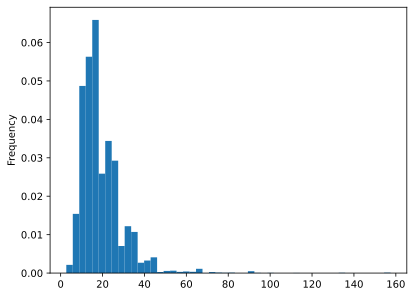

In [31]:
new_data['inc'].plot(kind='hist',bins=50,density=True)

In [32]:
new_data = get_category(new_data,'inc', 3, ["low","medium", "high"], qcut = True)
iv, data = calc_iv(new_data,'gp_inc','target')
ivtable.loc[ivtable['variable']=='inc','IV']=iv
data.head()

TypeError: ufunc 'isnan' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

In [ ]:
new_data = convert_dummy(new_data,'gp_inc')

#### Edad

In [ ]:
# crear variable edad 'Age' a partir de dias de nacimiento
new_data['Age']=-(new_data['DAYS_BIRTH'])//365	
print(new_data['Age'].value_counts(bins=10,normalize=True,sort=False))

(19.951999999999998, 24.7]    0.025066
(24.7, 29.4]                  0.134280
(29.4, 34.1]                  0.169770
(34.1, 38.8]                  0.140805
(38.8, 43.5]                  0.173072
(43.5, 48.2]                  0.141880
(48.2, 52.9]                  0.099069
(52.9, 57.6]                  0.076550
(57.6, 62.3]                  0.032585
(62.3, 67.0]                  0.006923
Name: Age, dtype: float64


<AxesSubplot:ylabel='Frequency'>

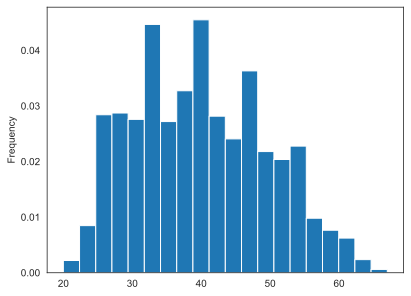

In [ ]:
new_data['Age'].plot(kind='hist',bins=20,density=True)

In [ ]:
new_data = get_category(new_data,'Age',5, ["lowest","low","medium","high","highest"])
iv, data = calc_iv(new_data,'gp_Age','target')
ivtable.loc[ivtable['variable']=='DAYS_BIRTH','IV'] = iv
data.head()

El IV de esta variable es: 0.06593513858884348
medium     7916
low        7806
high       4414
lowest     4005
highest     993
Name: gp_Age, dtype: int64


,Variable,Value,All,Good,Bad,Share,Bad Rate,Distribution Good,Distribution Bad,WoE,IV
0,gp_Age,high,4414,4323,91,0.175619,0.020616,0.174935,0.215640,-0.209194,0.008515
1,gp_Age,highest,993,989,4,0.039508,0.004028,0.040021,0.009479,1.440361,0.043992
2,gp_Age,low,7806,7686,120,0.310575,0.015373,0.311023,0.284360,0.089625,0.002390
3,gp_Age,lowest,4005,3921,84,0.159346,0.020974,0.158668,0.199052,-0.226754,0.009157
4,gp_Age,medium,7916,7793,123,0.314952,0.015538,0.315353,0.291469,0.078758,0.001881


In [ ]:
new_data = convert_dummy(new_data,'gp_Age')


#### Años de Trabajo

In [ ]:
# crear variable años de trabajo con dias empleado
new_data['worktm']=-(new_data['DAYS_EMPLOYED'])//365
# reemplazar NO empleado por NaN
new_data[new_data['worktm']<0] = np.nan # replace by na
new_data['DAYS_EMPLOYED']
new_data['worktm'].fillna(new_data['worktm'].mean(),inplace=True) #replace na by mean

<AxesSubplot:ylabel='Frequency'>

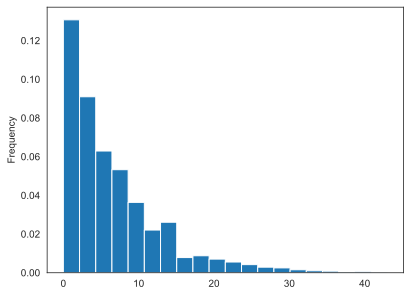

In [ ]:
new_data['worktm'].plot(kind='hist',bins=20,density=True)

In [ ]:
new_data = get_category(new_data,'worktm',5, ["lowest","low","medium","high","highest"])
iv, data=calc_iv(new_data,'gp_worktm','target')
ivtable.loc[ivtable['variable']=='DAYS_EMPLOYED','IV']=iv
data.head()

El IV de esta variable es: 0.04022152230816303
lowest     18254
low         4987
medium      1378
high         425
highest       90
Name: gp_worktm, dtype: int64


,Variable,Value,All,Good,Bad,Share,Bad Rate,Distribution Good,Distribution Bad,WoE,IV
0,gp_worktm,high,425,423,2,0.016909,0.004706,0.017117,0.004739,1.284186,0.015895
1,gp_worktm,highest,90,90,0,0.003581,0.000000,0.003642,0.000000,0.000000,0.000000
2,gp_worktm,low,4987,4921,66,0.198416,0.013234,0.199134,0.156398,0.241573,0.010324
3,gp_worktm,lowest,18254,17916,338,0.726267,0.018516,0.724992,0.800948,-0.099635,0.007568
4,gp_worktm,medium,1378,1362,16,0.054826,0.011611,0.055115,0.037915,0.374082,0.006434


In [ ]:
# Codificación One-Hot
new_data = convert_dummy(new_data,'gp_worktm')

#### Tamaño de Familia

In [ ]:
new_data['famsize'].value_counts(sort=False)

2.0     12697
1.0      4263
3.0      5216
4.0      2576
6.0        51
9.0         2
5.0       307
7.0        18
20.0        1
15.0        3
Name: famsize, dtype: int64

In [ ]:
# convertir new_data['famsize'] a int
new_data['famsize']=new_data['famsize'].astype(int)
new_data['famsizegp']=new_data['famsize']
# convertir new_data['famsize'] a object
new_data['famsizegp']=new_data['famsizegp'].astype(object)

# crear categorias para famisize
new_data.loc[new_data['famsizegp']>=3,'famsizegp']='3more'
iv, data=calc_iv(new_data,'famsizegp','target')
ivtable.loc[ivtable['variable']=='famsize','IV']=iv
data.head()

El IV de esta variable es: 0.006156138510778323
2        12697
3more     8174
1         4263
Name: famsizegp, dtype: int64


,Variable,Value,All,Good,Bad,Share,Bad Rate,Distribution Good,Distribution Bad,WoE,IV
0,famsizegp,1,4263,4179,84,0.169611,0.019704,0.169108,0.199052,-0.163028,0.004882
1,famsizegp,2,12697,12489,208,0.505172,0.016382,0.505382,0.492891,0.025027,0.000313
2,famsizegp,3more,8174,8044,130,0.325217,0.015904,0.325510,0.308057,0.055108,0.000962


In [ ]:
# Codificación One-Hot
new_data = convert_dummy(new_data,'famsizegp')

### Descriptores Categóricos

#### Forma de Ingresos

In [ ]:
# tipo de ingreso

# contar ingresos
print(new_data['inctp'].value_counts(sort=False))
print("")
print(new_data['inctp'].value_counts(normalize=True,sort=False))
new_data.loc[new_data['inctp']=='Pensioner','inctp']='State servant'
new_data.loc[new_data['inctp']=='Student','inctp']='State servant'
iv, data=calc_iv(new_data,'inctp','target')
ivtable.loc[ivtable['variable']=='inctp','IV']=iv
data.head()

Student                    10
Working                 15622
Pensioner                  13
State servant            2437
Commercial associate     7052
Name: inctp, dtype: int64

Student                 0.000398
Working                 0.621549
Pensioner               0.000517
State servant           0.096960
Commercial associate    0.280576
Name: inctp, dtype: float64
El IV de esta variable es: 5.159303327851404e-05
Working                 15622
Commercial associate     7052
State servant            2460
Name: inctp, dtype: int64


,Variable,Value,All,Good,Bad,Share,Bad Rate,Distribution Good,Distribution Bad,WoE,IV
0,inctp,Commercial associate,7052,6933,119,0.280576,0.016875,0.280552,0.281991,-0.005115,0.000007
1,inctp,State servant,2460,2418,42,0.097875,0.017073,0.097847,0.099526,-0.017013,0.000029
2,inctp,Working,15622,15361,261,0.621549,0.016707,0.621601,0.618483,0.005028,0.000016


In [ ]:
# Codificación One-Hot
new_data = convert_dummy(new_data,'inctp')

#### Tipo de Ocupación

In [ ]:
# crear categorias de tipo de ocupacion
new_data.loc[(new_data['occyp']=='Cleaning staff') | (new_data['occyp']=='Cooking staff') | (new_data['occyp']=='Drivers') | (new_data['occyp']=='Laborers') | (new_data['occyp']=='Low-skill Laborers') | (new_data['occyp']=='Security staff') | (new_data['occyp']=='Waiters/barmen staff'),'occyp']='Laborwk'
new_data.loc[(new_data['occyp']=='Accountants') | (new_data['occyp']=='Core staff') | (new_data['occyp']=='HR staff') | (new_data['occyp']=='Medicine staff') | (new_data['occyp']=='Private service staff') | (new_data['occyp']=='Realty agents') | (new_data['occyp']=='Sales staff') | (new_data['occyp']=='Secretaries'),'occyp']='officewk'
new_data.loc[(new_data['occyp']=='Managers') | (new_data['occyp']=='High skill tech staff') | (new_data['occyp']=='IT staff'),'occyp']='hightecwk'

# contar por categorias
print(new_data['occyp'].value_counts())
iv, data=calc_iv(new_data,'occyp','target')
ivtable.loc[ivtable['variable']=='occyp','IV']=iv
data.head()         

Laborwk      10496
officewk     10183
hightecwk     4455
Name: occyp, dtype: int64
El IV de esta variable es: 0.004820472062853304
Laborwk      10496
officewk     10183
hightecwk     4455
Name: occyp, dtype: int64


,Variable,Value,All,Good,Bad,Share,Bad Rate,Distribution Good,Distribution Bad,WoE,IV
0,occyp,Laborwk,10496,10311,185,0.417602,0.017626,0.417247,0.438389,-0.049428,0.001045
1,occyp,hightecwk,4455,4375,80,0.177250,0.017957,0.177039,0.189573,-0.068404,0.000857
2,occyp,officewk,10183,10026,157,0.405148,0.015418,0.405714,0.372038,0.086652,0.002918


In [ ]:
# crear dummies de variables categoricas
new_data = convert_dummy(new_data,'occyp')
new_data

,ID,Gender,Car,Reality,inc,edutp,famtp,houtp,DAYS_BIRTH,DAYS_EMPLOYED,...,gp_worktm_high,gp_worktm_highest,gp_worktm_low,gp_worktm_medium,famsizegp_1,famsizegp_3more,inctp_Commercial associate,inctp_State servant,occyp_hightecwk,occyp_officewk
2,5008806.0,1.0,1.0,1.0,11.25,Secondary / secondary special,Married,House / apartment,-21474.0,-1134.0,...,0,0,0,0,0,0,0,0,0,0
3,5008808.0,0.0,0.0,1.0,27,Secondary / secondary special,Single / not married,House / apartment,-19110.0,-3051.0,...,0,0,0,0,1,0,1,0,0,1
4,5008809.0,0.0,0.0,1.0,27,Secondary / secondary special,Single / not married,House / apartment,-19110.0,-3051.0,...,0,0,0,0,1,0,1,0,0,1
5,5008810.0,0.0,0.0,1.0,27,Secondary / secondary special,Single / not married,House / apartment,-19110.0,-3051.0,...,0,0,0,0,1,0,1,0,0,1
6,5008811.0,0.0,0.0,1.0,27,Secondary / secondary special,Single / not married,House / apartment,-19110.0,-3051.0,...,0,0,0,0,1,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36452,5149828.0,1.0,1.0,1.0,31.5,Secondary / secondary special,Married,House / apartment,-17348.0,-2420.0,...,0,0,0,0,0,0,0,0,1,0
36453,5149834.0,0.0,0.0,1.0,15.75,Higher education,Married,House / apartment,-12387.0,-1325.0,...,0,0,0,0,0,0,1,0,0,1
36454,5149838.0,0.0,0.0,1.0,15.75,Higher education,Married,House / apartment,-12387.0,-1325.0,...,0,0,0,0,0,0,0,1,0,1
36455,5150049.0,0.0,0.0,1.0,28.35,Secondary / secondary special,Married,House / apartment,-17958.0,-655.0,...,0,0,0,0,0,0,0,0,0,1


In [ ]:
new_data.columns

Index(['ID', 'Gender', 'Car', 'Reality', 'inc', 'edutp', 'famtp', 'houtp',
       'DAYS_BIRTH', 'DAYS_EMPLOYED', 'FLAG_MOBIL', 'wkphone', 'phone',
       'email', 'famsize', 'begin_month', 'dep_value', 'target', 'ChldNo_1',
       'ChldNo_2More', 'gp_inc_high', 'gp_inc_medium', 'Age', 'gp_Age_high',
       'gp_Age_highest', 'gp_Age_low', 'gp_Age_lowest', 'worktm',
       'gp_worktm_high', 'gp_worktm_highest', 'gp_worktm_low',
       'gp_worktm_medium', 'famsizegp_1', 'famsizegp_3more',
       'inctp_Commercial associate', 'inctp_State servant', 'occyp_hightecwk',
       'occyp_officewk'],
      dtype='object')

#### Forma de Vivienda

In [ ]:
iv, data=calc_iv(new_data,'houtp','target')
ivtable.loc[ivtable['variable']=='houtp','IV']=iv
data.head()

El IV de esta variable es: 0.0073275026880227365
House / apartment      22102
With parents            1430
Municipal apartment      812
Rented apartment         439
Office apartment         199
Co-op apartment          152
Name: houtp, dtype: int64


,Variable,Value,All,Good,Bad,Share,Bad Rate,Distribution Good,Distribution Bad,WoE,IV
0,houtp,Co-op apartment,152,149,3,0.006048,0.019737,0.006029,0.007109,-0.164705,0.000178
1,houtp,House / apartment,22102,21738,364,0.879367,0.016469,0.879654,0.862559,0.019624,0.000335
2,houtp,Municipal apartment,812,793,19,0.032307,0.023399,0.032090,0.045024,-0.338655,0.004380
3,houtp,Office apartment,199,194,5,0.007918,0.025126,0.007850,0.011848,-0.411619,0.001646
4,houtp,Rented apartment,439,433,6,0.017466,0.013667,0.017522,0.014218,0.208939,0.000690


In [ ]:
new_data = convert_dummy(new_data,'houtp')

In [ ]:
new_data.columns

Index(['ID', 'Gender', 'Car', 'Reality', 'inc', 'edutp', 'famtp', 'DAYS_BIRTH',
       'DAYS_EMPLOYED', 'FLAG_MOBIL', 'wkphone', 'phone', 'email', 'famsize',
       'begin_month', 'dep_value', 'target', 'ChldNo_1', 'ChldNo_2More',
       'gp_inc_high', 'gp_inc_medium', 'Age', 'gp_Age_high', 'gp_Age_highest',
       'gp_Age_low', 'gp_Age_lowest', 'worktm', 'gp_worktm_high',
       'gp_worktm_highest', 'gp_worktm_low', 'gp_worktm_medium', 'famsizegp_1',
       'famsizegp_3more', 'inctp_Commercial associate', 'inctp_State servant',
       'occyp_hightecwk', 'occyp_officewk', 'houtp_Co-op apartment',
       'houtp_Municipal apartment', 'houtp_Office apartment',
       'houtp_Rented apartment', 'houtp_With parents'],
      dtype='object')

#### Educación

In [ ]:
new_data.loc[new_data['edutp']=='Academic degree','edutp']='Higher education'
iv, data=calc_iv(new_data,'edutp','target')
ivtable.loc[ivtable['variable']=='edutp','IV']=iv
data.head()

El IV de esta variable es: 0.010361794017679489
Secondary / secondary special    16808
Higher education                  7146
Incomplete higher                  993
Lower secondary                    187
Name: edutp, dtype: int64


,Variable,Value,All,Good,Bad,Share,Bad Rate,Distribution Good,Distribution Bad,WoE,IV
0,edutp,Higher education,7146,7018,128,0.284316,0.017912,0.283992,0.303318,-0.065836,0.001272
1,edutp,Incomplete higher,993,972,21,0.039508,0.021148,0.039333,0.049763,-0.235206,0.002453
2,edutp,Lower secondary,187,181,6,0.007440,0.032086,0.007324,0.014218,-0.663301,0.004573
3,edutp,Secondary / secondary special,16808,16541,267,0.668736,0.015885,0.669351,0.632701,0.056310,0.002064


In [ ]:
new_data = convert_dummy(new_data,'edutp')

In [ ]:
new_data.columns

Index(['ID', 'Gender', 'Car', 'Reality', 'inc', 'famtp', 'DAYS_BIRTH',
       'DAYS_EMPLOYED', 'FLAG_MOBIL', 'wkphone', 'phone', 'email', 'famsize',
       'begin_month', 'dep_value', 'target', 'ChldNo_1', 'ChldNo_2More',
       'gp_inc_high', 'gp_inc_medium', 'Age', 'gp_Age_high', 'gp_Age_highest',
       'gp_Age_low', 'gp_Age_lowest', 'worktm', 'gp_worktm_high',
       'gp_worktm_highest', 'gp_worktm_low', 'gp_worktm_medium', 'famsizegp_1',
       'famsizegp_3more', 'inctp_Commercial associate', 'inctp_State servant',
       'occyp_hightecwk', 'occyp_officewk', 'houtp_Co-op apartment',
       'houtp_Municipal apartment', 'houtp_Office apartment',
       'houtp_Rented apartment', 'houtp_With parents',
       'edutp_Higher education', 'edutp_Incomplete higher',
       'edutp_Lower secondary'],
      dtype='object')

####  Estado Civil

In [ ]:
new_data['famtp'].value_counts(normalize=True,sort=False)

Single / not married    0.137065
Married                 0.696626
Widow                   0.023076
Civil marriage          0.084865
Separated               0.058367
Name: famtp, dtype: float64

In [ ]:
iv, data=calc_iv(new_data,'famtp','target')
ivtable.loc[ivtable['variable']=='famtp','IV']=iv
data.head()

El IV de esta variable es: 0.043137115423127946
Married                 17509
Single / not married     3445
Civil marriage           2133
Separated                1467
Widow                     580
Name: famtp, dtype: int64


,Variable,Value,All,Good,Bad,Share,Bad Rate,Distribution Good,Distribution Bad,WoE,IV
0,famtp,Civil marriage,2133,2101,32,0.084865,0.015002,0.085019,0.075829,0.114394,0.001051
1,famtp,Married,17509,17232,277,0.696626,0.015820,0.697313,0.656398,0.060467,0.002474
2,famtp,Separated,1467,1452,15,0.058367,0.010225,0.058757,0.035545,0.502608,0.011666
3,famtp,Single / not married,3445,3362,83,0.137065,0.024093,0.136047,0.196682,-0.368588,0.022349
4,famtp,Widow,580,565,15,0.023076,0.025862,0.022863,0.035545,-0.441263,0.005596


In [ ]:
new_data = convert_dummy(new_data,'famtp')

In [ ]:
new_data.columns

Index(['ID', 'Gender', 'Car', 'Reality', 'inc', 'DAYS_BIRTH', 'DAYS_EMPLOYED',
       'FLAG_MOBIL', 'wkphone', 'phone', 'email', 'famsize', 'begin_month',
       'dep_value', 'target', 'ChldNo_1', 'ChldNo_2More', 'gp_inc_high',
       'gp_inc_medium', 'Age', 'gp_Age_high', 'gp_Age_highest', 'gp_Age_low',
       'gp_Age_lowest', 'worktm', 'gp_worktm_high', 'gp_worktm_highest',
       'gp_worktm_low', 'gp_worktm_medium', 'famsizegp_1', 'famsizegp_3more',
       'inctp_Commercial associate', 'inctp_State servant', 'occyp_hightecwk',
       'occyp_officewk', 'houtp_Co-op apartment', 'houtp_Municipal apartment',
       'houtp_Office apartment', 'houtp_Rented apartment',
       'houtp_With parents', 'edutp_Higher education',
       'edutp_Incomplete higher', 'edutp_Lower secondary',
       'famtp_Civil marriage', 'famtp_Separated', 'famtp_Single / not married',
       'famtp_Widow'],
      dtype='object')

## Utilidad de: IV y WoE

# Puede leer el artículo a continuación para comprender un poco más sobre los conceptos de IV y WoE:

https://docs.tibco.com/pub/sfire-dsc/6.5.0/doc/html/TIB_sfire-dsc_user-guide/GUID-07A78308-525A-406F-8221-9281F4E9D7CF.html

La tabla a continuación fue tomada de la referencia indicada:

| IV| Ability to predict | 
|:------|:------:| 
| <0.02 | Bajo poder predictivo | 
|0.02~0.1 |Poder predictivo débil|
|0.1~0.3|Poder predictivo moderado|
|0.3~0.5|Poder predictivo fuerte|
|>0.5|Sospechosamente alto, revisar esta variable| 

In [ ]:
# crear tabla ivtable pesos/poder predictivo de variables
# sort_values(by='col',ascending=False):  organizar por columna, de mayor a menor 
ivtable=ivtable.sort_values(by='IV',ascending=False)
ivtable.loc[ivtable['variable']=='DAYS_BIRTH','variable']='agegp'
ivtable.loc[ivtable['variable']=='DAYS_EMPLOYED','variable']='worktmgp'
ivtable.loc[ivtable['variable']=='inc','variable']='incgp'
ivtable

,variable,IV
10,agegp,0.0659351
8,famtp,0.0431371
11,worktmgp,0.0402215
3,Reality,0.0274407
1,Gender,0.0252035
7,edutp,0.0103618
9,houtp,0.0073275
17,famsize,0.00615614
16,occyp,0.00482047
5,incgp,0.002422


# Predicción de Buen/Mal Cliente Mediante Redes Neuronales

+ Split Dataset

In [ ]:
new_data.columns

Index(['ID', 'Gender', 'Car', 'Reality', 'inc', 'DAYS_BIRTH', 'DAYS_EMPLOYED',
       'FLAG_MOBIL', 'wkphone', 'phone', 'email', 'famsize', 'begin_month',
       'dep_value', 'target', 'ChldNo_1', 'ChldNo_2More', 'gp_inc_high',
       'gp_inc_medium', 'Age', 'gp_Age_high', 'gp_Age_highest', 'gp_Age_low',
       'gp_Age_lowest', 'worktm', 'gp_worktm_high', 'gp_worktm_highest',
       'gp_worktm_low', 'gp_worktm_medium', 'famsizegp_1', 'famsizegp_3more',
       'inctp_Commercial associate', 'inctp_State servant', 'occyp_hightecwk',
       'occyp_officewk', 'houtp_Co-op apartment', 'houtp_Municipal apartment',
       'houtp_Office apartment', 'houtp_Rented apartment',
       'houtp_With parents', 'edutp_Higher education',
       'edutp_Incomplete higher', 'edutp_Lower secondary',
       'famtp_Civil marriage', 'famtp_Separated', 'famtp_Single / not married',
       'famtp_Widow'],
      dtype='object')

Se tomarán únicamente aquellas columnas preprocesadas y con un $IV>0.001$

In [ ]:
# crear variable y obs/target a predecir
Y = new_data['target']

# crear base x de variables pre-procesadas
X = new_data[['Gender','Reality','ChldNo_1', 'ChldNo_2More', 'gp_inc_medium',  'gp_inc_high','wkphone',
              'gp_Age_high', 'gp_Age_highest', 'gp_Age_low',
              'gp_Age_lowest','gp_worktm_high', 'gp_worktm_highest',
              'gp_worktm_low', 'gp_worktm_medium','occyp_hightecwk', 
              'occyp_officewk','famsizegp_1', 'famsizegp_3more',
              'houtp_Co-op apartment', 'houtp_Municipal apartment',
              'houtp_Office apartment', 'houtp_Rented apartment',
              'houtp_With parents','edutp_Higher education',
              'edutp_Incomplete higher', 'edutp_Lower secondary','famtp_Civil marriage',
              'famtp_Separated','famtp_Single / not married','famtp_Widow']]

### SMOTE

Concepto: Synthetic Minority Over-Sampling Technique(`SMOTE`) utilizado para lidiar con datos desbalanceados. Puede encontrar más información en:

- http://glemaitre.github.io/imbalanced-learn/generated/imblearn.over_sampling.SMOTE.html
- https://machinelearningmastery.com/smote-oversampling-for-imbalanced-classification/

In [ ]:
X

,Gender,Reality,ChldNo_1,ChldNo_2More,gp_inc_medium,gp_inc_high,wkphone,gp_Age_high,gp_Age_highest,gp_Age_low,...,houtp_Office apartment,houtp_Rented apartment,houtp_With parents,edutp_Higher education,edutp_Incomplete higher,edutp_Lower secondary,famtp_Civil marriage,famtp_Separated,famtp_Single / not married,famtp_Widow
2,1.0,1.0,0.0,0.0,0.0,0.0,0,0.0,1.0,0.0,...,0,0,0,0,0,0,0,0,0,0
3,0.0,1.0,0.0,0.0,0.0,1.0,0,1.0,0.0,0.0,...,0,0,0,0,0,0,0,0,1,0
4,0.0,1.0,0.0,0.0,0.0,1.0,0,1.0,0.0,0.0,...,0,0,0,0,0,0,0,0,1,0
5,0.0,1.0,0.0,0.0,0.0,1.0,0,1.0,0.0,0.0,...,0,0,0,0,0,0,0,0,1,0
6,0.0,1.0,0.0,0.0,0.0,1.0,0,1.0,0.0,0.0,...,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36452,1.0,1.0,0.0,0.0,0.0,1.0,0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
36453,0.0,1.0,0.0,0.0,1.0,0.0,0,0.0,0.0,1.0,...,0,0,0,1,0,0,0,0,0,0
36454,0.0,1.0,0.0,0.0,1.0,0.0,0,0.0,0.0,1.0,...,0,0,0,1,0,0,0,0,0,0
36455,0.0,1.0,0.0,0.0,0.0,1.0,0,1.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
Y = Y.astype('int')

# SMOTE() crear clase que hace oversampling
sm = SMOTE(random_state = None )

# sm.fit_resample(X,Y)  crear nueva base con oversampling 
X_balance,Y_balance = sm.fit_resample(X,Y)
X_balance = pd.DataFrame(X_balance, columns = X.columns)

X_balance

,Gender,Reality,ChldNo_1,ChldNo_2More,gp_inc_medium,gp_inc_high,wkphone,gp_Age_high,gp_Age_highest,gp_Age_low,...,houtp_Office apartment,houtp_Rented apartment,houtp_With parents,edutp_Higher education,edutp_Incomplete higher,edutp_Lower secondary,famtp_Civil marriage,famtp_Separated,famtp_Single / not married,famtp_Widow
0,1.00000,1.000000,0.0,0.0,0.000000,0.0,0,0.0,1.0,0.0,...,0,0,0,0,0,0,0,0,0,0
1,0.00000,1.000000,0.0,0.0,0.000000,1.0,0,1.0,0.0,0.0,...,0,0,0,0,0,0,0,0,1,0
2,0.00000,1.000000,0.0,0.0,0.000000,1.0,0,1.0,0.0,0.0,...,0,0,0,0,0,0,0,0,1,0
3,0.00000,1.000000,0.0,0.0,0.000000,1.0,0,1.0,0.0,0.0,...,0,0,0,0,0,0,0,0,1,0
4,0.00000,1.000000,0.0,0.0,0.000000,1.0,0,1.0,0.0,0.0,...,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49419,1.00000,0.130818,0.0,0.0,0.000000,1.0,0.869182,0.0,0.0,1.0,...,0,0,0,0,0,0,0,0,1,0
49420,1.00000,0.000000,1.0,0.0,0.560025,0.0,0.439975,0.0,0.0,1.0,...,0,0,0,0,0,0,0,0,0,0
49421,0.00000,1.000000,0.0,0.0,0.705903,0.0,0.705903,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,1
49422,0.00000,0.000000,0.0,0.0,1.000000,0.0,1,0.0,0.0,0.0,...,0,0,0,1,0,0,0,0,0,0


Separación de datos en conjuntos: entrenamiento y prueba.

In [ ]:
# split/dividir base en train-set y test-set

# train_test_split(x,y,train_size,test_size,random_state(seed))
X_train, X_test, y_train, y_test = train_test_split(X_balance,Y_balance, 
                                                    stratify=Y_balance, test_size=0.3,
                                                    random_state = 10086)

# \*Seleccione esta celda y luego la opción `Run All Above`\*

# PARTE 1

## Separación de Conjunto de Features

Teniendo en cuenta los resultados de IV obtenidos anteriormente, comprobaremos la capacidad predictiva de tres conjuntos de datos basados en la tabla anterior. Primero removeremos los últimos cuatro ('phone', 'inctp', 'email', 'Car'), y luego realizaremos la siguiente división:

- A. Primera mitad: 'agegp', 'famtp', 'worktmgp', 'Reality', 'Gender', 'edutp'
- B. Segunda mitad: 'houtp', 'famsize', 'occyp', 'incgp', 'wkphone', 'ChldNo'
- C. Todos los descriptores.

De acuerdo a estos nombres, utilice la siguiente lista para identificar aquellos solicitados en cada caso:
```
    'Gender','Reality','ChldNo_1', 'ChldNo_2More', 'gp_inc_medium',  'gp_inc_high','wkphone',
    'gp_Age_high', 'gp_Age_highest', 'gp_Age_low',
    'gp_Age_lowest','gp_worktm_high', 'gp_worktm_highest',
    'gp_worktm_low', 'gp_worktm_medium','occyp_hightecwk', 
    'occyp_officewk','famsizegp_1', 'famsizegp_3more',
    'houtp_Co-op apartment', 'houtp_Municipal apartment',
    'houtp_Office apartment', 'houtp_Rented apartment',
    'houtp_With parents','edutp_Higher education',
    'edutp_Incomplete higher', 'edutp_Lower secondary','famtp_Civil marriage',
    'famtp_Separated','famtp_Single / not married','famtp_Widow'
```
### A. Top 6

In [ ]:
X_train_subA = X_train[['gp_Age_high','gp_Age_highest','gp_Age_low','gp_Age_lowest',
                       'famtp_Civil marriage','famtp_Separated', 'famtp_Single / not married','famtp_Widow',
                       'gp_worktm_high','gp_worktm_highest','gp_worktm_low','gp_worktm_medium',
                       'Reality',
                       'Gender',
                       'edutp_Higher education','edutp_Incomplete higher','edutp_Lower secondary']]       
  
    
X_test_subA = X_test[['gp_Age_high','gp_Age_highest','gp_Age_low','gp_Age_lowest',
                       'famtp_Civil marriage','famtp_Separated', 'famtp_Single / not married','famtp_Widow',
                       'gp_worktm_high','gp_worktm_highest','gp_worktm_low','gp_worktm_medium',
                       'Reality',
                       'Gender',
                       'edutp_Higher education','edutp_Incomplete higher','edutp_Lower secondary']]
X_train_subA
X_test_subA

,gp_Age_high,gp_Age_highest,gp_Age_low,gp_Age_lowest,famtp_Civil marriage,famtp_Separated,famtp_Single / not married,famtp_Widow,gp_worktm_high,gp_worktm_highest,gp_worktm_low,gp_worktm_medium,Reality,Gender,edutp_Higher education,edutp_Incomplete higher,edutp_Lower secondary
24205,0.000000,0.0,0.0,0.0,0,0,0,0,0,0,0,0,1.000000,0.0,0,0,0
39804,0.000000,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0.000000,0.0,0,0,0
10003,0.000000,0.0,0.0,0.0,0,0,0,0,0,0,0,0,1.000000,0.0,1,0,0
45484,0.000000,0.0,0.0,1.0,0,0,0,0,0,0,0,0,0.000000,0.0,0,1,0
25645,0.194989,0.0,0.0,0.0,0,0,0,0,0,0,0,0,1.000000,0.0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41229,0.000000,0.0,0.0,1.0,0,0,0,0,0,0,0,0,0.000000,1.0,0,1,0
24933,1.000000,0.0,0.0,0.0,0,0,1,0,0,0,0,0,0.000000,1.0,0,0,0
7233,0.000000,0.0,0.0,1.0,0,0,0,0,0,0,0,0,0.000000,1.0,0,0,0
39047,1.000000,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0.279343,0.0,0,0,0


### B. Últimos 6
B. Segunda mitad: 'houtp', 'famsize', 'occyp', 'incgp', 'wkphone', 'ChldNo'

In [33]:
X_train_subB = X_train[['houtp_Co-op apartment','houtp_Municipal apartment','houtp_Office apartment','houtp_Rented apartment','houtp_With parents',
                        'famsizegp_1','famsizegp_3more',
                        'occyp_hightecwk', 'occyp_officewk',
                        'gp_inc_medium','gp_inc_high',
                        'wkphone',
                        'ChldNo_1','ChldNo_2More'
                       ]]

X_test_subB = X_test[['houtp_Co-op apartment','houtp_Municipal apartment','houtp_Office apartment','houtp_Rented apartment','houtp_With parents',
                        'famsizegp_1','famsizegp_3more',
                        'occyp_hightecwk', 'occyp_officewk',
                        'gp_inc_medium','gp_inc_high',
                        'wkphone',
                        'ChldNo_1','ChldNo_2More'
                       ]]
X_test_subB.head()

NameError: name 'X_train' is not defined

## Caso C

Acá simplemente tomaremos, no es necesario crear nuevas variables:
```
X_train_subC = X_train
X_test_subC = X_test
```

# PARTE 2

Implementación de pruebas en los conjuntos de descriptores. A continuación debe implementar, inicialmente tres modelos de regresión logística, y posteriormente tres redes neuronales (2 capas escondidas, 20 neuronas en cada una). Observe los resultados y analice lo sucedido. Concluya sobre qué modelo es deseable teniendo en cuenta la factibilidad de implementación práctica y la matriz de confusión correspondiente.

## Regresión Logística

Inicialmente se probará un modelo de regresión logística para tener una referencia (también se conoce como _baseline_) y comprobar que un modelo de red neuronal permite obtener mejores resultados.

$$\log ({p \over {1 - p}}) = {\beta _0} + {\beta _1}{x_1} +  \cdot  \cdot  \cdot  + {\beta _q}{x_q}$$

### Caso A

## Metricas de evaluacion
accuracy_score, precision_score, recall_score, f1_score, balanced_accuracy_score, confusion_matrix 

In [1]:
# crear LogisticRegression regresion logistica
# los estimadores se ajustan con MLE
model = LogisticRegression(C=0.8,
                           random_state=0,
                           solver='lbfgs')

# ajustar modelo LogisticRegression con base A (MLE)
model.fit(X_train_subA, y_train) # Ajuste el modelo con los datos del conjunto A #

# crear vector y_hat de predicciones con X_test
y_predict = model.predict(X_test_subA) # Realice la predicción de etiquetas con los datos de prueba del conjunto A #


# calcular metricas de evaluacion
print(f'Accuracy {round(accuracy_score(y_test, y_predict),5)}')
print(f'Precision {round(precision_score(y_test, y_predict),5)}')
print(f'Sensitivity/Recall {round(recall_score(y_test, y_predict),5)}')
print(f'Balanced Accuracy {round(balanced_accuracy_score(y_test, y_predict),5)}')
print(f'F1 {round(f1_score(y_test, y_predict),5)}')


# crear matriz de confusion

print(type(y_test), type(y_predict))
print(pd.DataFrame(confusion_matrix(y_test,y_predict)))

sns.set_style('white') 
class_names = ['0','1']
plot_confusion_matrix(confusion_matrix(y_test,y_predict),
                      classes= class_names, 
                      title='Matriz de Confusión Normalizada: Regresión Logística')

NameError: name 'LogisticRegression' is not defined

## Caso B

Accuracy 0.564
Precision 0.5621
Sensitivity/Recall 0.57931
Balanced Accuracy 0.564
F1 0.57057
      0     1
0  4068  3346
1  3119  4295
[[4068 3346]
 [3119 4295]]


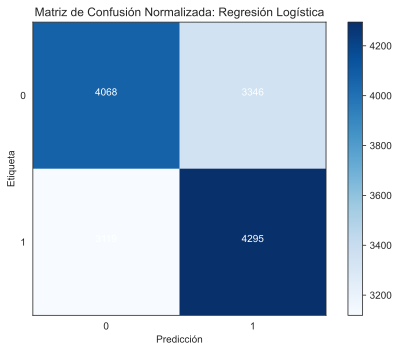

In [ ]:
# crear modelo LogisticRegression regresion logistica (MLE)
model = LogisticRegression(C=0.8,
                           random_state=0,
                           solver='lbfgs')

# ajustar predictores/estimadores de modelo LogisticRegression mediante MLE
model.fit(X_train_subB, y_train) # Ajuste el modelo con los datos del conjunto B #

# crear vector de predicciones usando x-test set
y_predict = model.predict(X_test_subB) # Realice la predicción de etiquetas con los datos de prueba del conjunto B #

# calcular metricas de evaluacion
print(f'Accuracy {round(accuracy_score(y_test, y_predict),5)}')
print(f'Precision {round(precision_score(y_test, y_predict),5)}')
print(f'Sensitivity/Recall {round(recall_score(y_test, y_predict),5)}')
print(f'Balanced Accuracy {round(balanced_accuracy_score(y_test, y_predict),5)}')
print(f'F1 {round(f1_score(y_test, y_predict),5)}')



print(pd.DataFrame(confusion_matrix(y_test,y_predict)))

sns.set_style('white') 
class_names = ['0','1']
plot_confusion_matrix(confusion_matrix(y_test,y_predict),
                      classes= class_names, 
                      title='Matriz de Confusión Normalizada: Regresión Logística')


## Caso C

Accuracy 0.65201
Precision 0.63259
Sensitivity/Recall 0.72525
Balanced Accuracy 0.65201
F1 0.67576
      0     1
0  4291  3123
1  2037  5377
[[4291 3123]
 [2037 5377]]


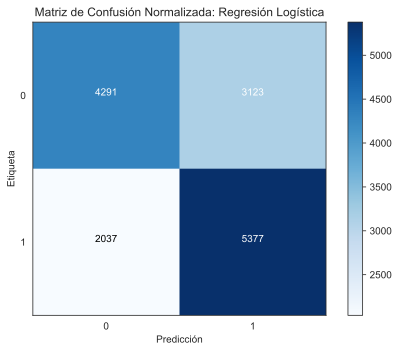

In [ ]:
# crear modelo LogisticRegression regresión logistica. parametro C=0.8 de regularizacion
model = LogisticRegression(C=0.8,
                           random_state=0,
                           solver='lbfgs')
# ajustar modelo con train-set C
model.fit(X_train,y_train) # Ajuste el modelo con los datos del conjunto C #

# crear y_hat vector de predicciones con x-test
y_predict = model.predict(X_test) # Realice la predicción de etiquetas con los datos de prueba del conjunto C #

# calcular metricas de evaluacion
print(f'Accuracy {round(accuracy_score(y_test, y_predict),5)}')
print(f'Precision {round(precision_score(y_test, y_predict),5)}')
print(f'Sensitivity/Recall {round(recall_score(y_test, y_predict),5)}')
print(f'Balanced Accuracy {round(balanced_accuracy_score(y_test, y_predict),5)}')
print(f'F1 {round(f1_score(y_test, y_predict),5)}')


print(pd.DataFrame(confusion_matrix(y_test,y_predict)))

sns.set_style('white') 
class_names = ['0','1']
plot_confusion_matrix(confusion_matrix(y_test,y_predict),
                      classes= class_names, 
                      title='Matriz de Confusión Normalizada: Regresión Logística')


## Red Neuronal, Perceptrón Multicapa

Ahora utilice la función `MLPClassifier` de la librería SciKit-Learn para desarrollar una red neuronal que permita mejorar el rendimiento del clasificador _baseline_ desarrollado.

### Caso A

Accuracy 0.74757
Precision 0.70311
Sensitivity/Recall 0.85703
Balanced Accuracy 0.74757
F1 0.77248
      0     1
0  4731  2683
1  1060  6354
[[4731 2683]
 [1060 6354]]


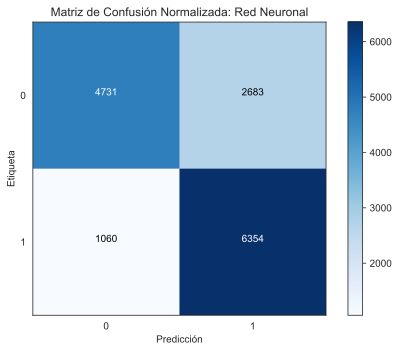

In [ ]:
from sklearn.neural_network import MLPClassifier

# crear red neuronal MLPClassifier
# parametros: hidden_layer_sizes = (#neuronas en ith capa), activation = 'activation func'


model = MLPClassifier( hidden_layer_sizes = (20, 20) , activation ='relu') # Inicialice un modelo de red neuronal con 2 capas escondidas x 20 neuronas en cada capa y función de activación ReLu #

# ajustar modelo con train-set(oversampled) con back-propagation 
model.fit(X_train_subA, y_train) # Ajuste el modelo con los datos del conjunto A #

# crear y_hat vector de predicciones con x-test A
y_predict = model.predict(X_test_subA) # Realice la predicción de etiquetas con los datos de prueba del conjunto A #


# calcular metricas de evaluacion
print(f'Accuracy {round(accuracy_score(y_test, y_predict),5)}')
print(f'Precision {round(precision_score(y_test, y_predict),5)}')
print(f'Sensitivity/Recall {round(recall_score(y_test, y_predict),5)}')
print(f'Balanced Accuracy {round(balanced_accuracy_score(y_test, y_predict),5)}')
print(f'F1 {round(f1_score(y_test, y_predict),5)}')


print(pd.DataFrame(confusion_matrix(y_test,y_predict)))

plot_confusion_matrix(confusion_matrix(y_test,y_predict),
                      classes=class_names, 
                      title='Matriz de Confusión Normalizada: Red Neuronal')

### Caso B

Accuracy 0.73375
Precision 0.71887
Sensitivity/Recall 0.76774
Balanced Accuracy 0.73375
F1 0.7425
      0     1
0  5188  2226
1  1722  5692
[[5188 2226]
 [1722 5692]]


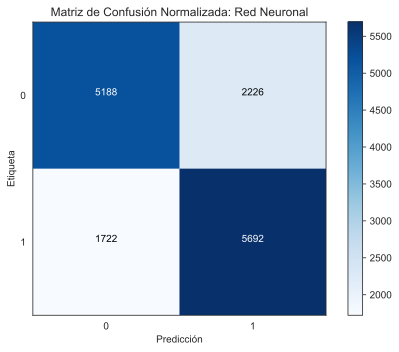

In [ ]:
from sklearn.neural_network import MLPClassifier

# crear modelo de red neuronal MLPClassifier
# parametros: hidden_layer_sizes(#neuronas/nodos en ith capa), activation = 'funcion de activacion'
model = MLPClassifier(hidden_layer_sizes = (20, 20) , activation ='relu') # Inicialice un modelo de red neuronal con 2 capas escondidas x 20 neuronas en cada capa y función de activación ReLu #

# ajustar predictores/parametros de modelo con train-set B
model.fit(X_train_subB, y_train) # Ajuste el modelo con los datos del conjunto B #

# crear y_hat vector de predictores con x-test B
y_predict = model.predict(X_test_subB) # Realice la predicción de etiquetas con los datos de prueba del conjunto B #

# calcular metricas de evaluacion
print(f'Accuracy {round(accuracy_score(y_test, y_predict),5)}')
print(f'Precision {round(precision_score(y_test, y_predict),5)}')
print(f'Sensitivity/Recall {round(recall_score(y_test, y_predict),5)}')
print(f'Balanced Accuracy {round(balanced_accuracy_score(y_test, y_predict),5)}')
print(f'F1 {round(f1_score(y_test, y_predict),5)}')


print(pd.DataFrame(confusion_matrix(y_test,y_predict)))

plot_confusion_matrix(confusion_matrix(y_test,y_predict),
                      classes=class_names, 
                      title='Matriz de Confusión Normalizada: Red Neuronal')

### Caso C

Accuracy 0.91718
Precision 0.89972
Sensitivity/Recall 0.93903
Balanced Accuracy 0.91718
F1 0.91895
      0     1
0  6638   776
1   452  6962
[[6638  776]
 [ 452 6962]]


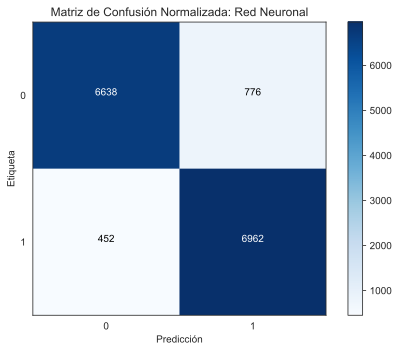

In [ ]:
from sklearn.neural_network import MLPClassifier

model = MLPClassifier( hidden_layer_sizes = (20, 20) , activation ='relu') # Inicialice un modelo de red neuronal con 2 capas escondidas x 20 neuronas en cada capa y función de activación ReLu #

model.fit(X_train,y_train) # Ajuste el modelo con los datos del conjunto C #
y_predict = model.predict(X_test) # Realice la predicción de etiquetas con los datos de prueba del conjunto Cmm #

# calcular metricas de evaluacion
print(f'Accuracy {round(accuracy_score(y_test, y_predict),5)}')
print(f'Precision {round(precision_score(y_test, y_predict),5)}')
print(f'Sensitivity/Recall {round(recall_score(y_test, y_predict),5)}')
print(f'Balanced Accuracy {round(balanced_accuracy_score(y_test, y_predict),5)}')
print(f'F1 {round(f1_score(y_test, y_predict),5)}')

print(pd.DataFrame(confusion_matrix(y_test,y_predict)))

plot_confusion_matrix(confusion_matrix(y_test,y_predict),
                      classes=class_names, 
                      title='Matriz de Confusión Normalizada: Red Neuronal')

### Conclusiones Parte 2

Concluya con respecto a sus resultados.

In [ ]:
# specificity = TN/(TN+FP)
tn, fp, fn, tp = confusion_matrix(y_train, y_hat_train ).ravel()
spec_train = tn / (tn+fp)

tn, fp, fn, tp = confusion_matrix(y_test, y_hat_test ).ravel()
spec_test = tn / (tn+fp)

NameError: name 'y_hat_train' is not defined

# PARTE 3

Los resultados obtenidos para las redes neuronales anteriores únicamente corresponden a una arquitectura. Un proceso necesario e importante en casos de estudio como este es la búsqueda de hiperparámetros, en este caso, el número de neuronas más adecuado (al menos dentro de cierto rango, este proceso también se conoce como [GridSearch](https://towardsdatascience.com/grid-search-for-model-tuning-3319b259367e)).

**Divida el conjunto de datos de prueba en dos mitades: datos de validación y datos de prueba. Utilice los datos de validación para realizar una evaluación preliminar de cada modelo.** Utilice `train_test_split` para esta parte.

Utilice todos los descriptores para esta prueba y realice las siguientes búsquedas:

- Caso A: 1 capa escondida $\times$ {5, 10, 20, 50, 100} neuronas.
- Caso B: 2 capas escondidas $\times$ {5, 10, 20, 50, 100} neuronas.
- Caso C: 3 capas escondidas $\times$ {5, 10, 20, 50, 100} neuronas.

Utilice `matplotlib.pyplot` para graficar la precisión en los datos de validación, seleccione el mejor modelo, y obtenga una evaluación final para esta selección utilizando los datos de prueba.

In [ ]:
# dividir base en train-set y test-set con base con imbalance techniques
X_train, X_test, y_train, y_test = train_test_split(X_balance,Y_balance, 
                                                    stratify=Y_balance, test_size=0.2,
                                                    random_state = 1006)

# dividir test-set en validation-set y evaluation-set con la base de test-set
X_val, X_test, y_val, y_test = train_test_split(X_test,y_test, 
                                                    test_size=0.2,
                                                    random_state = 1123)

X_eval

### Caso A

In [ ]:
# crear lista de metricas de evaluacion a graficar
acc_list = []
prec_list = []
rec_list = []
spec_list = []
bal_acc_list = []
f1_list = []

# crear hiper parámetros óptimos y métrica óptima
spec_opt = 0
layer_opt = None


# crear red neuronal MLPClassifier, parametros:  random_state = seed
#neural_net1 = MLPClassifier(random_state=1000) # Inicialice un modelo de red neuronal con 2 capas escondidas x 20 neuronas en cada capa y función de activación ReLu #

# crear grid de #capas x #neuronas
grid_values = [(5),(10),(20),(50),(100)]

# recorrer #capas x #neuronas 
for layer in grid_values:
    
    # crear red neuronal MLPClassifier, parametros:  hidden_layer_sizes = layer, activation = 'relu',  random_state = seed
    neural_net1 = MLPClassifier(hidden_layer_sizes = layer , activation = 'relu' ,random_state=1000) # Inicialice un modelo de red neuronal con 2 capas escondidas x 20 neuronas en cada capa y función de activación ReLu #
    
    # ajustar modelo con train-set 
    neural_net1.fit(X_train,y_train)
    
    # crear y_hat de predicciones con validation-set
    y_predict =  neural_net1.predict(X_val)
    
    
    # agregar metricas de evaluacion para graficar con validation-set y  y_hat de predicciones
    acc_list.append(round(accuracy_score(y_val, y_predict),5))
    prec_list.append(round(precision_score(y_val, y_predict),5))
    rec_list.append(round(recall_score(y_val, y_predict),5))
    
    
    # specificity = TN/(TN+FP)
    tn, fp, fn, tp = confusion_matrix(y_val, y_predict ).ravel()
    spec = tn / (tn+fp)
    
    #tn, fp, fn, tp = confusion_matrix(y_test, y_hat_test ).ravel()
    #spec_test = tn / (tn+fp)
    
    spec_list.append(round(spec,5))
    
    
    bal_acc_list.append(round(balanced_accuracy_score(y_val, y_predict),5))
    f1_list.append(round(f1_score(y_val, y_predict),5))
    
    # calcular metricas de evaluacion
    print(f'Accuracy {round(accuracy_score(y_val, y_predict),5)}')
    print(f'Precision {round(precision_score(y_val, y_predict),5)}')
    print(f'Sensitivity/Recall:TPR {round(recall_score(y_val, y_predict),5)}')
    print(f'Specificity:TNR {round(spec,5)}')
    print(f'Balanced Accuracy {round(balanced_accuracy_score(y_val, y_predict),5)}')
    print(f'F1 {round(f1_score(y_val, y_predict),5)}')
    
    # creara DataFrame de matriz de Confusion para cada arquitectura
    print(pd.DataFrame(confusion_matrix(y_val,y_predict)))
    print("")
    #plot_confusion_matrix(confusion_matrix(y_val,y_predict),
    #                      classes=class_names, 
    #                      title='Matriz de Confusión Normalizada: Configuración :' + str(layer))
    
    
    # escoger mejor modelo 
    if spec>spec_opt:
        spec_opt = spec
        layer_opt = layer
        
# crear gráficas superpuestas
plt.plot(grid_values,acc_list, color='b', label='accuracy')
plt.plot(grid_values,prec_list, color='g', label='precision')
plt.plot(grid_values,rec_list, color='r', label='recall/TPR')
plt.plot(grid_values,spec_list, color='m', label='specificity/TNR')
plt.plot(grid_values,bal_acc_list, color='c', label='balanced accuracy')
plt.plot(grid_values,f1_list, color='y', label='f1')

# nombre de ejes 
plt.xlabel("Arquitectura de Red Neuronal")
plt.ylabel("Score/Performance %")
plt.title("Metricas de evaluación: Red Neuronal 1 Capa")

# agregar leyenda, a partir de labels de cada grafica
plt.legend()
# mostrar grafica
plt.show()

# Mejor modelo de grupo
print("El mejor modelo de grupo A tiene: ")
print("Arquitectura: #Capas x #Neuronas: " + str(layer_opt))
print("La Especificidad óptimo es: " + str(spec_opt))



### Caso B

In [ ]:
# crear lista de metricas de evaluacion a graficar
acc_list = []
prec_list = []
rec_list = []
spec_list = []
bal_acc_list = []
f1_list = []

# crear hiper parámetros óptimos y métrica óptima
spec_opt = 0
layer_opt = None

# crear red neuronal MLPClassifier, parametros:  random_state = seed
#neural_net1 = MLPClassifier(random_state=1000) # Inicialice un modelo de red neuronal con 2 capas escondidas x 20 neuronas en cada capa y función de activación ReLu #

# crear grid de #capas x #neuronas
grid_values = [(5,5),(10,10),(20,20),(50,50),(100,100)]

# recorrer #capas x #neuronas 
for layer in grid_values:
    
    # crear red neuronal MLPClassifier, parametros:  hidden_layer_sizes = layer, activation = 'relu',  random_state = seed
    neural_net2 = MLPClassifier(hidden_layer_sizes = layer , activation = 'relu' ,random_state=1000) # Inicialice un modelo de red neuronal con 2 capas escondidas x 20 neuronas en cada capa y función de activación ReLu #
    
    # ajustar modelo con train-set 
    neural_net2.fit(X_train,y_train)
    
    # crear y_hat de predicciones con validation-set
    y_predict =  neural_net2.predict(X_val)
    
    
    # agregar metricas de evaluacion para graficar con validation-set y  y_hat de predicciones
    acc_list.append(round(accuracy_score(y_val, y_predict),5))
    prec_list.append(round(precision_score(y_val, y_predict),5))
    rec_list.append(round(recall_score(y_val, y_predict),5))
    
    
    # specificity = TN/(TN+FP)
    tn, fp, fn, tp = confusion_matrix(y_val, y_predict ).ravel()
    spec = tn / (tn+fp)
    
    #tn, fp, fn, tp = confusion_matrix(y_test, y_hat_test ).ravel()
    #spec_test = tn / (tn+fp)
    
    spec_list.append(round(spec,5))
    
    
    bal_acc_list.append(round(balanced_accuracy_score(y_val, y_predict),5))
    f1_list.append(round(f1_score(y_val, y_predict),5))
    
    # calcular metricas de evaluacion
    print(f'Accuracy {round(accuracy_score(y_val, y_predict),5)}')
    print(f'Precision {round(precision_score(y_val, y_predict),5)}')
    print(f'Sensitivity/Recall:TPR {round(recall_score(y_val, y_predict),5)}')
    print(f'Specificity:TNR {round(spec,5)}')
    print(f'Balanced Accuracy {round(balanced_accuracy_score(y_val, y_predict),5)}')
    print(f'F1 {round(f1_score(y_val, y_predict),5)}')
    
    
    print(type (y_val))
    print(type (y_predict))
    # creara DataFrame de matriz de Confusion para cada arquitectura
    print(pd.DataFrame(confusion_matrix(y_val,y_predict)))
    print("")
    #plot_confusion_matrix(confusion_matrix(y_val,y_predict),
    #                      classes=class_names, 
    #                      title='Matriz de Confusión Normalizada: Configuración :' + str(layer))
    
        # escoger mejor modelo 
    if spec>spec_opt:
        spec_opt = spec
        layer_opt = layer
    
# crear gráficas superpuestas
plt.plot(grid_values,acc_list, color='b', label='accuracy')
plt.plot(grid_values,prec_list, color='g', label='precision')
plt.plot(grid_values,rec_list, color='r', label='recall/TPR')
plt.plot(grid_values,spec_list, color='m', label='specificity/TNR')
plt.plot(grid_values,bal_acc_list, color='c', label='balanced accuracy')
plt.plot(grid_values,f1_list, color='y', label='f1')

# nombre de ejes 
plt.xlabel("Arquitectura de Red Neuronal")
plt.ylabel("Score/Performance %")
plt.title("Metricas de evaluación: Red Neuronal 2 Capas")

# agregar leyenda, a partir de labels de cada grafica
plt.legend()
# mostrar grafica
plt.show()


# Mejor modelo de grupo
print("El mejor modelo de grupo A tiene: ")
print("Arquitectura: #Capas x #Neuronas: " + str(layer_opt))
print("La Especificidad óptimo es: " + str(spec_opt))



NameError: name 'MLPClassifier' is not defined

### Caso C

In [ ]:
# crear lista de metricas de evaluacion a graficar
acc_list = []
prec_list = []
rec_list = []
spec_list = []
bal_acc_list = []
f1_list = []

# crear hiper parámetros óptimos y métrica óptima
spec_opt = 0
layer_opt = None


# crear red neuronal MLPClassifier, parametros:  random_state = seed
#neural_net1 = MLPClassifier(random_state=1000) # Inicialice un modelo de red neuronal con 2 capas escondidas x 20 neuronas en cada capa y función de activación ReLu #

# crear grid de #capas x #neuronas
grid_values = [(5,5,5),(10,10,10),(20,20,20),(50,50,50),(100,100,100)]

# recorrer #capas x #neuronas 
for layer in grid_values:
    
    # crear red neuronal MLPClassifier, parametros:  hidden_layer_sizes = layer, activation = 'relu',  random_state = seed
    neural_net3 = MLPClassifier(hidden_layer_sizes = layer , activation = 'relu' ,random_state=1000) # Inicialice un modelo de red neuronal con 2 capas escondidas x 20 neuronas en cada capa y función de activación ReLu #
    
    # ajustar modelo con train-set 
    neural_net3.fit(X_train,y_train)
    
    # crear y_hat de predicciones con validation-set
    y_predict =  neural_net3.predict(X_val)
    
    
    # agregar metricas de evaluacion para graficar con validation-set y  y_hat de predicciones
    acc_list.append(round(accuracy_score(y_val, y_predict),5))
    prec_list.append(round(precision_score(y_val, y_predict),5))
    rec_list.append(round(recall_score(y_val, y_predict),5))
    
    
    # specificity = TN/(TN+FP)
    tn, fp, fn, tp = confusion_matrix(y_val, y_predict ).ravel()
    spec = tn / (tn+fp)
    
    #tn, fp, fn, tp = confusion_matrix(y_test, y_hat_test ).ravel()
    #spec_test = tn / (tn+fp)
    
    spec_list.append(round(spec,5))
    
    
    bal_acc_list.append(round(balanced_accuracy_score(y_val, y_predict),5))
    f1_list.append(round(f1_score(y_val, y_predict),5))
    
    # calcular metricas de evaluacion
    print(f'Accuracy {round(accuracy_score(y_val, y_predict),5)}')
    print(f'Precision {round(precision_score(y_val, y_predict),5)}')
    print(f'Sensitivity/Recall:TPR {round(recall_score(y_val, y_predict),5)}')
    print(f'Specificity:TNR {round(spec,5)}')
    print(f'Balanced Accuracy {round(balanced_accuracy_score(y_val, y_predict),5)}')
    print(f'F1 {round(f1_score(y_val, y_predict),5)}')
    
    # creara DataFrame de matriz de Confusion para cada arquitectura
    print(pd.DataFrame(confusion_matrix(y_val,y_predict)))
    print("")
    #plot_confusion_matrix(confusion_matrix(y_val,y_predict),
    #                      classes=class_names, 
    #                      title='Matriz de Confusión Normalizada: Configuración :' + str(layer))
    
    # escoger mejor modelo 
    if spec>spec_opt:
        spec_opt = spec
        layer_opt = layer
    
# crear gráficas superpuestas
plt.plot(grid_values,acc_list, color='b', label='accuracy')
plt.plot(grid_values,prec_list, color='g', label='precision')
plt.plot(grid_values,rec_list, color='r', label='recall/TPR')
plt.plot(grid_values,spec_list, color='m', label='specificity/TNR')
plt.plot(grid_values,bal_acc_list, color='c', label='balanced accuracy')
plt.plot(grid_values,f1_list, color='y', label='f1')

# nombre de ejes 
plt.xlabel("Arquitectura de Red Neuronal")
plt.ylabel("Score/Performance %")
plt.title("Metricas de evaluación: Red Neuronal 3 Capas")

# agregar leyenda, a partir de labels de cada grafica
plt.legend()
# mostrar grafica
plt.show()


# Mejor modelo de grupo
print("El mejor modelo de grupo A tiene: ")
print("Arquitectura: #Capas x #Neuronas: " + str(layer_opt))
print("La Especificidad óptimo es: " + str(spec_opt))



# Realizar validación cruzada con las mejores configuraciones de cada aequitectura
# escoger a partir de metricas de evaluacion sobre evaluation-set


### FALTA TERMINAR


In [ ]:
# entrenar modelo óptimo con mejor arquitectura
# crear red neuronal MLPClassifier, parametros:  hidden_layer_sizes = layer, activation = 'relu',  random_state = seed
neural_opt = MLPClassifier(hidden_layer_sizes =  (50, 50) , activation = 'relu' ,random_state=1000) # Inicialice un modelo de red neuronal con 2 capas escondidas x 50 neuronas en cada capa y función de activación ReLu #
    
# ajustar/entrenar modelo con train-set 
neural_opt.fit(X_train,y_train)
    
# crear y_hat de predicciones con X_test
y_predict =  neural_net3.predict(X_test)
    
    
# agregar metricas de evaluacion para graficar con validation-set y  y_hat de predicciones
acc = round(accuracy_score(y_test, y_predict),5)

prec = round(precision_score(y_test, y_predict),5)
rec = round(recall_score(y_test, y_predict),5)

# specificity = TN/(TN+FP)
tn, fp, fn, tp = confusion_matrix(y_test, y_predict ).ravel()
spec = tn / (tn+fp)
    
#tn, fp, fn, tp = confusion_matrix(y_test, y_hat_test ).ravel()
#spec_test = tn / (tn+fp) 
#spec_list.append(round(spec,5))

bal_acc = round(balanced_accuracy_score(y_test, y_predict),5)
f1 = round(f1_score(y_test, y_predict),5)
    
# calcular metricas de evaluacion
print(f'Accuracy {round(accuracy_score(y_test, y_predict),5)}')
print(f'Precision {round(precision_score(y_test, y_predict),5)}')
print(f'Sensitivity/Recall:TPR {round(recall_score(y_test, y_predict),5)}')
print(f'Specificity:TNR {round(spec,5)}')
print(f'Balanced Accuracy {round(balanced_accuracy_score(y_test, y_predict),5)}')
print(f'F1 {round(f1_score(y_test, y_predict),5)}')
    
# creara DataFrame de matriz de Confusion para cada arquitectura
print(pd.DataFrame(confusion_matrix(y_test,y_predict)))
print("")
#plot_confusion_matrix(confusion_matrix(y_val,y_predict),
#                      classes=class_names, 
#                      title='Matriz de Confusión Normalizada: Configuración :' + str(layer))


# crear bar graph de las métricas de evaluación

data = {'Specificity': spec, 'Accuracy':acc, 'Precision':prec, 'Recall':rec, 'Balanced Accuracy':bal_acc, 'F1':f1}

# asignar valores de x: metricas
x = list(data.keys())
# asignar valores de y: score/performance %
y = list(data.values())

# crear figure
fig = plt.figure (figsize = (10,5))

# plot bar: parametros x, y, color, width
plt.bar(x, y, color = ['red','blue','blue','blue','blue','blue'], width=0.4)


plt.xlabel("Métrica ")
plt.ylabel("Score/Performance %")
plt.title("Métricas de Evaluación: Modelo óptimo 2 capas x 50 neuronas")
plt.show()



In [ ]:
# inicializar w: vector de los estimadores/predictores del modelo
# w0 es el vector de estimadores inicial aleatorio que solo se usa en la primera iteración
w0 = np.random.rand(X_train.shape[1]) # Inicialización de w #w = w0.copy()
# w vector de estimadores/predictores que se va a actualizar
w= w0.copy()
w_ant=w0

X_train

a = np.add(X_train,w)
a

In [ ]:
# # # # Implemente el método de backpropagation para la arquitectura seleccionada # # # #
#
#
#
#
#
#
# ...   

# inicializar w: vector de los estimadores/predictores del modelo
# w0 es el vector de estimadores inicial aleatorio que solo se usa en la primera iteración
w0 = np.random.rand(X_train.shape[1]) # Inicialización de w #w = w0.copy()
# w vector de estimadores/predictores que se va a actualizar
w= w0.copy()
w_ant=w0


# variables de control sobre el algoritmo 
# Inicialización de criterio de parada (al disminuir el valor de eps, se aumenta la precisión y el tiempo de procesamiento)
eps = 1e-3 # epsilon que es el umbral del error para asegurar convergencia
error0 = float('inf') # se inicializa el error
dif = float('inf') # se inicializa la diferencia de los errores en 100 (default)


# calcular la tasa de aprendizaje optima
#xtx = np.dot(x_train_array.transpose(), x_train_array)
#vp = np.linalg.eigvals(xtx)
#max_vp = np.sqrt(max(vp))
#tasa0 = (2/max_vp)-0.001

# tasa de aprendizaje
tasa = 0.001 # constante

# numero de iteraciones en las que converge el algoritmo
n = 0


# definir la función de activación: Redes Neuronales

# parámetros: wi predictores/estimadores actuales, xi x actual el punto estocástico
# función de activación NO LINEAL: ReLu
def relu(z):
    if z>0:
        return z
    else:
        return 0

# parametros de validacion cruzada a sintonizar
n_opt=float('inf') # numero de iteraciones para convergencia
dif_opt = float('inf')
w_opt = w0

# metricas de evaluacion optimas
acc_opt = 0
prec_opt = 0
rec_opt = 0
f1_opt = 0
bal_opt = 0


# lista de errores para evaluar el aprendizaje del algoritmo
errores = [] # agregar los errores a la lista en cada iteración
errores.append(error0)

# lista de z: salida de la función de activación en cada neurona

#z0 =
#z = np.

# valores de prueba
dif = 10
eps = 0

# iterar por número de capas
for layer in hidden_layers:
    # iterar por número de nodos(neuronas)
    for node in num_nodes:
        ### Algoritmo Back-Propagation (en linea: batch = 1)
        while dif > eps:
            # escoger el punto aleatorio
            
            # punto de mini batch estocástico extremo n =1
            i = np.random.randint(X_train.shape[0])
            xActual = X_train[i] #X_train_array[i]
            yActual = y_train[i]
            
            
            # Fordward Pass: calcular zi de la neurona
            a_j = np.add(X_train,w)
            
            # aplicar función de activación a suma (combinación lineal)
            # de pesos wjk y predictores x
            
            
            
            
            
            
            # Back Propagation: calcular delta (errores) de la neurona
            
            
            
            
            # Actualizar pesos wjk  
            
            
            
            


# Bono (2 puntos)

Implemente el mejor modelo de red neuronal. Desarrolle el método de **_backpropagation_** para realizar el entrenamiento de la red sin utilizar ningún tipo de librería que tenga funciones prestablecidas con objetivos de apoyo en el tema de Machine Learning. Puede utilizar Numpy, Pandas, etc. NO puede utilizar: SciKit-Learn, Tensorflow/Keras, PyTorch, etc.

El bono debe estar COMPLETO y se debe observar una curva de aprendizaje a través de las iteraciones que permita obtener resultados aceptables con respecto a la red definida a partir de SciKit-Learn. De lo contrario, no se tomará como válido.

In [ ]:
# # # # Implemente el método de backpropagation para la arquitectura seleccionada # # # #
#
#
#
#
#
#
# ...

# inicializar w: vector de los estimadores/predictores del modelo
# w0 es el vector de estimadores inicial aleatorio que solo se usa en la primera iteración
w0 = np.random.rand(X_train.shape[1]) # Inicialización de w #w = w0.copy()
# w vector de estimadores/predictores que se va a actualizar
w= w0.copy()
w_ant=w0


# variables de control sobre el algoritmo 
# Inicialización de criterio de parada (al disminuir el valor de eps, se aumenta la precisión y el tiempo de procesamiento)
eps = 1e-3 # epsilon que es el umbral del error para asegurar convergencia
error0 = float('inf') # se inicializa el error
dif = float('inf') # se inicializa la diferencia de los errores en 100 (default)


# calcular la tasa de aprendizaje optima
xtx = np.dot(x_train_array.transpose(), x_train_array)
vp = np.linalg.eigvals(xtx)
max_vp = np.sqrt(max(vp))
tasa0 = (2/max_vp)-0.001

# tasas de aprendizaje
tasas = np.linspace(0,0.5,100) # Defina un vector que contenga las tasas de aprendizaje que desea probar #


# lista de errores para evaluar el aprendizaje del algoritmo
errores = [] # agregar los errores a la lista en cada iteración
errores.append(error0)

# numero de iteraciones en las que converge el algoritmo
n = 0

# definir la función de activación: para el caso de regresión logistica
# la función de activación es la función sigmoide (regresión logística)
# la función sigmoide(sigma) es la probabilidad dada por el modelo con parámetros w
# que la observacion xi pertenezca a la clase k (k=1)


# el gradiente en la regresion logistica es la función sigmoide (probabilidad de pertenencia) de xi con parámetros/estimadores wi MLE  

# parámetros: wi predictores/estimadores actuales, xi x actual el punto estocástico

# función de activación NO LINEAL: ReLu
def relu(z):
    if z>0:
        return z
    else:
        return 0
    
    
# parametros de validacion cruzada a sintonizar
n_opt=float('inf') # numero de iteraciones para convergencia
dif_opt = float('inf')
w_opt = w0

# metricas de evaluacion optimas
acc_opt = 0
prec_opt = 0
rec_opt = 0
f1_opt = 0
bal_opt = 0



# valores de prueba
dif = 10
eps = 0

# algoritmo back-propagation 
# encontrar los pesos wjk que minimice la función de error 
# por medio de back-propagation (calculo del error)

# itera sobre las tasas de aprendizaje
for tasa in tasas:
    # itera sobre el umbral de cálculo de probabilidad
    for c in umbrales:
        
        # estimar vector w óptimo
        # criterio de parada cuando diferencia de errores en iteracion (wk - wk-1)   es menor que eps
        
        ### Algoritmo de Gradiente Descendente para converger a w  (mini-batch estocástico = 1)
        while dif > eps:
            # escoger el punto aleatorio
            
            # punto de mini batch estocástico extremo n =1
            i = np.random.randint(x_train_array.shape[0])
            xActual = x_train_array[i] #X_train_array[i]
            yActual = y_train_array[i]
        
            # calculo del gradiente, aplicando la funcion logistica sigmoide de activación
            gradiente_log = sigma(w,xActual)   
        
            # error: yi-gradiente_log(sigmoide(w,xi))
            error = yActual - gradiente_log
            errores.append(error)
        
            # calcular/actualizar el vector de estimadores/predictores
            w = w_ant+tasa*error*xActual
        
            # calcular la diferencia de errores para comparar con umbral de convergencia eps
            dif = np.abs(errores[-1]-errores[-2]) 
            w_ant = w
            n+=1
            #eps+=1
            
            
        
        ### Evaluar el vector w de convergencia de Gradiente Descendente para realizar las predicciones
        x_test_array = np.c_[np.ones(x_test.values.shape[0]), x_test.values]
        y_test_array = y_test.values   
        
        # crear vector de y_predict de predicciones
        y_predict = np.zeros(len(x_test_array))
        #c = 0.5 # umbral de Probabilidad de Bernoulli
        
        # recorre vector y_predict de predicciones
        # predice para la etiqueta de x_test_array[i]: clase k[0-1]
        # calcula la función sigma de verosimilitud de probabilidad de pertenencia
        
        
        # recorre el vector x-test sobre el cual se va a realizar predicciones de etiquetas binarias
        # con el calculo de funcion sigma de w ajustado y x_test[i] para un c dado
        for i in range(0, len(x_test_array)):
            # calculo de probabilidad  (MLE) de x-test[i] con vector w de pesos
            prob_sigma = sigma(w, x_test_array[i])
            if prob_sigma>c:
                y_predict[i]=1
            else:
                y_predict[i]=0
                
                
        # crear matriz de confusión: métricas de evaluacion en clasificación 
        #cm = confusion_matrix(y_test,y_predict)   
        #conf_matrix = pd.DataFrame(data=cm,columns=['Predicted:0','Predicted:1'],index=['Actual:0','Actual:1'])
        #plt.figure(figsize = (8,5))
        #sn.heatmap(conf_matrix, annot=True,fmt='d',cmap="YlGnBu")
        
        
        # calcular métricas de evaluación
        acc = accuracy_score(y_test,y_predict)   
        prec = precision_score(y_test,y_predict)
        rec = recall_score(y_test,y_predict)
        f1 = f1_score(y_test,y_predict)
        bal = balanced_accuracy_score(y_test,y_predict)
        
        # agregar metricas de evaluacion a listas
        acc_list.append(acc) 
        prec_list.append(prec)
        rec_list.append(rec)
        f1_list.append(f1)
        bal_list.append(bal)
            
        print(f'Accuracy {round(acc,5)}')
        print(f'Precision {round(prec,5)}')
        print(f'Sensitivity/Recall:TPR {round(rec,5)}')
        #print(f'Specificity:TNR {round(spec,5)}')
        print(f'Balanced Accuracy {round(bal,5)}')
        print(f'F1 {round(f1,5)} \n')
            
            
        # scoring: dependiendo de la métrica de evaluacion que se quiere maximizar
        if acc > acc_opt:
            acc_opt = acc
            
            # actualizar hiper parámetros óptimos 
            tasa_opt = tasa
            c_opt = c
            n_opt = n
            dif_opt = dif
            w_opt = w
            
            # actualizar métricas de evaluación óptimas
            prec_opt = prec
            rec_opt = rec
            f1_opt = f1
            bal_opt = bal
            
            
data_metricas = {'Accuracy':acc_opt,'Precision':prec_opt, 'Recall':rec_opt, 'F1 Score':f1_score, 'Balanced Accuracy': bal_opt}
data_hp = {'Tasa de Aprendizaje':tasa_opt, 'Umbral de Decisión':c_opt}


df_hp = pd.DataFrame([[key, data_hp[key]] for key in data_hp.keys()], columns=['Hiperparámetros ', 'Valor'])
df_metricas = pd.DataFrame([[key, data_metricas[key]] for key in data_metricas.keys()], columns=['Mejores Metricas ', 'Valor'])



print("El número de iteraciones en las que convergió el algorimto de Gradiente Descendente Estocástico es: "+str(n_opt)) 
print("La diferencia de errores en la última iteración es: "+ str(dif_opt))
print("El vector de predictores/estimadores w_opt que mejor ajusta el modelo es: " + str(w_opt))

print("El mejor modelo se obtiene con los hiperparámetros: ")
print(data_hp)

print("Las métricas de evaluación del mejor modelo son: ")
print(df_metricas)



